(groups_comparison_notebook)=
# Confronto tra due (o più) gruppi

Lo scopo di questo capitolo è estendere la discussione del capitolo {ref}`bayes_one_mean_notebook`. Esamineremo, in particolare, le predizioni predittive a priori -- ovvero, verificheremo che le assunzioni che introduciamo nel modello siano sensate. Estenderemo poi la discussione al confronto tra più gruppi. Iniziamo a caricare le librerie necessarie.

In [1]:
from pymc import HalfNormal, HalfCauchy, Model, Normal, sample
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.constants import golden
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

SEED = 42
rng = np.random.default_rng(SEED)
sns.set_theme()
sns.set_palette("colorblind")
plt.rc('figure', figsize=(5.0, 5.0/golden))

## Stima della media di un gruppo

Iniziamo con il caso che abbiamo già discusso nel capitolo precedente, ovvero la stima dell'incertezza relativa alla media di un gruppo. Qui useremo i dati Palmer penguin.  Li leggo da un file csv ed escludo i dati mancanti:

In [3]:
penguins = pd.read_csv("data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

Ottengo in questo modo 333 righe e 8 colonne. Posso quindi calcolare la media del peso `body_mass_g` in funzione della specie:

In [4]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Ottengo in questo modo le stime puntuali sia per la media che per la dispersione dei dati nel campione, ma non conosco l'incertezza di queste statistiche. Ovvero, non so come questi valori varieranno se esaminerò un altro campione. Un modo per ottenere stime dell'incertezza è quello di utilizzare i metodi bayesiani. Per fare ciò abbiamo bisogno di ipotizzare una relazione tra le osservazioni e i parametri di un modello statistico. Ad esempio:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

laddove per la verosimilianza possiamo utilizzare una densità Normale. Possiamo usare una Normale 
quale distribuzione a priori per $\mu \sim \mathcal{N}(4000, 2000)$, mentre per $\sigma$ qui utilizzeremo una Normale troncata: $\sigma \sim \mathcal{HN}(2000)$.

Seleziono unicamente i pinguini della specie Adelie e recupero i valori della variabile `body_mass_g`:

In [5]:
adelie_mask = penguins["species"] == "Adelie"
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values
print(adelie_mass_obs)

[3750. 3800. 3250. 3450. 3650. 3625. 4675. 3200. 3800. 4400. 3700. 3450.
 4500. 3325. 4200. 3400. 3600. 3800. 3950. 3800. 3800. 3550. 3200. 3150.
 3950. 3250. 3900. 3300. 3900. 3325. 4150. 3950. 3550. 3300. 4650. 3150.
 3900. 3100. 4400. 3000. 4600. 3425. 3450. 4150. 3500. 4300. 3450. 4050.
 2900. 3700. 3550. 3800. 2850. 3750. 3150. 4400. 3600. 4050. 2850. 3950.
 3350. 4100. 3050. 4450. 3600. 3900. 3550. 4150. 3700. 4250. 3700. 3900.
 3550. 4000. 3200. 4700. 3800. 4200. 3350. 3550. 3800. 3500. 3950. 3600.
 3550. 4300. 3400. 4450. 3300. 4300. 3700. 4350. 2900. 4100. 3725. 4725.
 3075. 4250. 2925. 3550. 3750. 3900. 3175. 4775. 3825. 4600. 3200. 4275.
 3900. 4075. 2900. 3775. 3350. 3325. 3150. 3500. 3450. 3875. 3050. 4000.
 3275. 4300. 3050. 4000. 3325. 3500. 3500. 4475. 3425. 3900. 3175. 3975.
 3400. 4250. 3400. 3475. 3050. 3725. 3000. 3650. 4250. 3475. 3450. 3750.
 3700. 4000.]


Implemento il modello descritto sopra usando PyMC. Prima di effettuare il campionamento della distribuzione a posteriori, però, esamino la distribuzione predittiva a priori per verificare l'adeguatezza della assunzioni relative alle distribuzioni a priori dei parametri. Per questo uso la funzione `pm.sample_prior_predictive()`. Genero 1000 valori casuli dalle distribuzioni a priori dei due parametri.

In [6]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=2000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata1 = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [mass, mu, sigma]


Dall'oggetto inferenceData `idata1` recupero le distribuzioni a priori e le passo a `az.plot_trace()`:

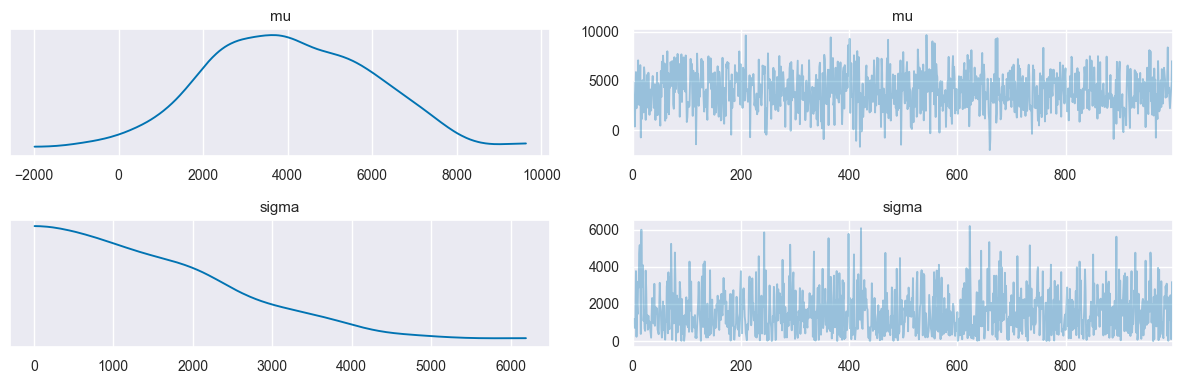

In [25]:
prior = idata1.prior
_ = az.plot_trace(prior)
plt.tight_layout()

Dall'esame delle distribuzioni a priori dei due parameti è evidente che non stiamo vincolando eccessivamente il campionamento della variabile `adelie_mass_obs`. Potremmo anzi avere scelto delle distribuzioni a priori troppo larghe, considerato che la distribuzione a priori per $\mu$ include anche valori negativi. Tuttavia, poiché questo è un modello semplice e abbiamo un discreto numero di osservazioni, non dobbiamo preoccuparci.  Passiamo dunque alla stima della distribuzione a posteriori.

In [8]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=2000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata2 = pm.sample(3000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 35 seconds.


Il KDE ploy e il rank plot della distribuzione a posteriori dei parametri del modello bayesiano servono come strumenti diagnostici visivi per aiutarci a capire se ci sono stati problemi durante il campionamento. Non vi sono evidenze di alcun problema.

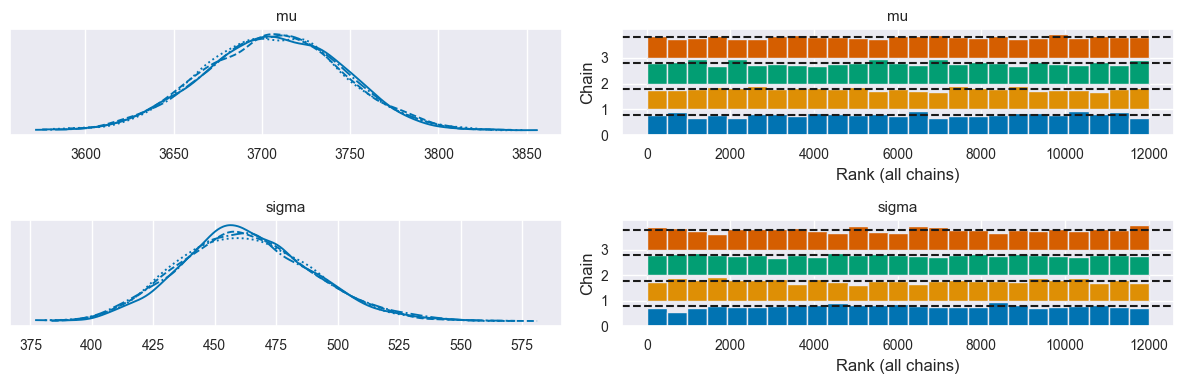

In [24]:
axes = az.plot_trace(idata2, divergences="bottom", kind="rank_bars")
plt.tight_layout()

Possiamo combinare le quattro catene. Un confronto tra la stima della distribuzione a posteriori e le stime puntuali dei due parametri che abbiamo ottenuto dal campione (linee verticali) è fornito nella figura seguente.

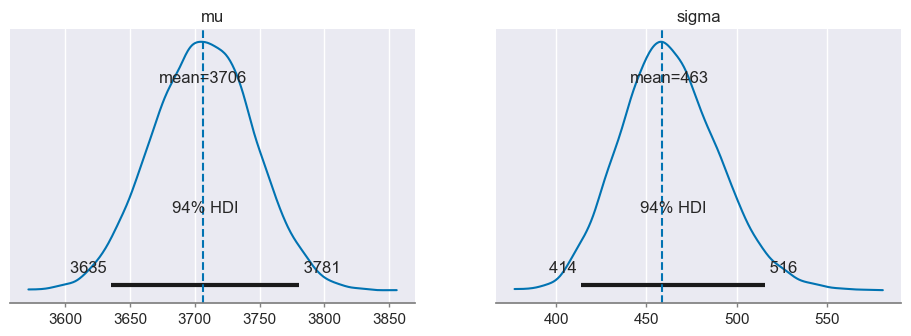

In [10]:
axes = az.plot_posterior(idata2, hdi_prob=0.94)

axes[0].axvline(3706.2, linestyle="--")
axes[1].axvline(458.6, linestyle="--")

Con la stima bayesiana otteniamo una distribuzione dei valori credibili dei parametri. Nelle distribuzioni a posteriori che abbiamo ottenuto per $\mu$ e $\sigma$, le stime campionarie rappresentano il valore più credibile, ma abbiamo imparato qual è la gamma di valori all'interno della quale ci possiamo aspettare che si trovi il "vero" valore del parametro. L'intervallo di valori plausibili è piuttosto stretto per $\mu$ (diciamo, tra 3636 a 3782), ma è piuttosto ampio per $\sigma$. Ricordiamo che la distribuzione a posteriori di $\mu$ non è la distribuzione di quelli che ci aspettiamo siano i valori della massa di un campione di pinguini -- quella distribuzione corrisponde alla distribuzione predittiva a posteriori. Invece, la distribuzione a posteriori di $\mu$ descrive la nostra incertezza sul parametro $\mu$ del *meccanismo generatore dei dati* che produce tutti gli infiniti possibili valori di massa dei pinguini.

Un sommario numerico viene generato con le istruzioni seguenti:

In [11]:
az.summary(idata2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3706.44,38.78,3635.41,3780.70,0.35,0.25,12364.0,8545.0,1.0
sigma,462.84,27.34,413.80,515.74,0.25,0.18,11968.0,8189.0,1.0


## Confonto tra più gruppi

In [12]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])

In [13]:
with pm.Model() as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    sigma = pm.HalfNormal("sigma", sigma=2000, shape=3)
    mu = pm.Normal("mu", 4000, 2000, shape=3)
    mass = pm.Normal(
        "mass",
        mu=mu[all_species.codes],
        sigma=sigma[all_species.codes],
        observed=penguins["body_mass_g"],
    )

    idata3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


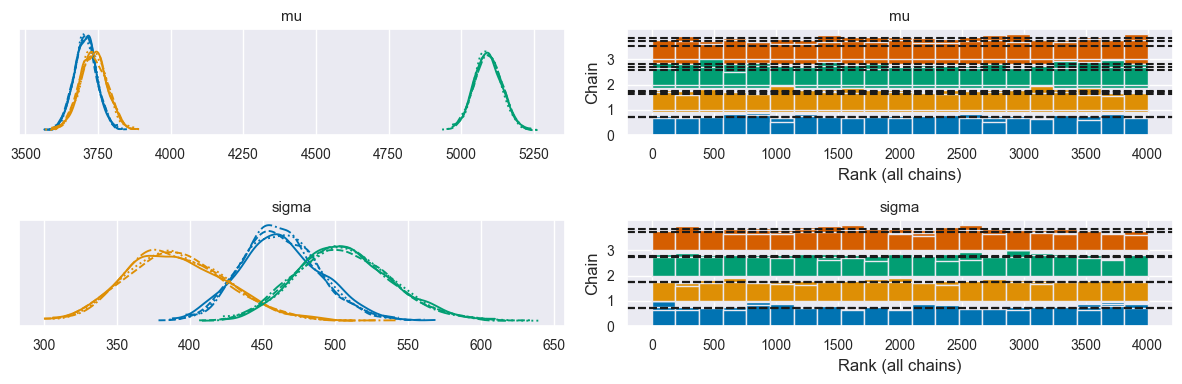

In [23]:
axes = az.plot_trace(idata3, divergences="bottom", kind="rank_bars")
plt.tight_layout()

In [15]:
az.summary(idata3).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3706.38,39.07,3633.76,3780.19,0.53,0.38,5438.0,3421.0,1.0
mu[1],3734.16,46.58,3647.60,3822.03,0.64,0.45,5340.0,3319.0,1.0
mu[2],5092.04,46.54,5000.21,5175.99,0.66,0.46,5043.0,3325.0,1.0
sigma[0],462.65,27.06,414.16,515.26,0.36,0.26,5785.0,2984.0,1.0
sigma[1],391.66,34.87,329.40,456.45,0.51,0.37,4781.0,3488.0,1.0
sigma[2],506.16,32.92,447.73,570.52,0.45,0.32,5348.0,3239.0,1.0


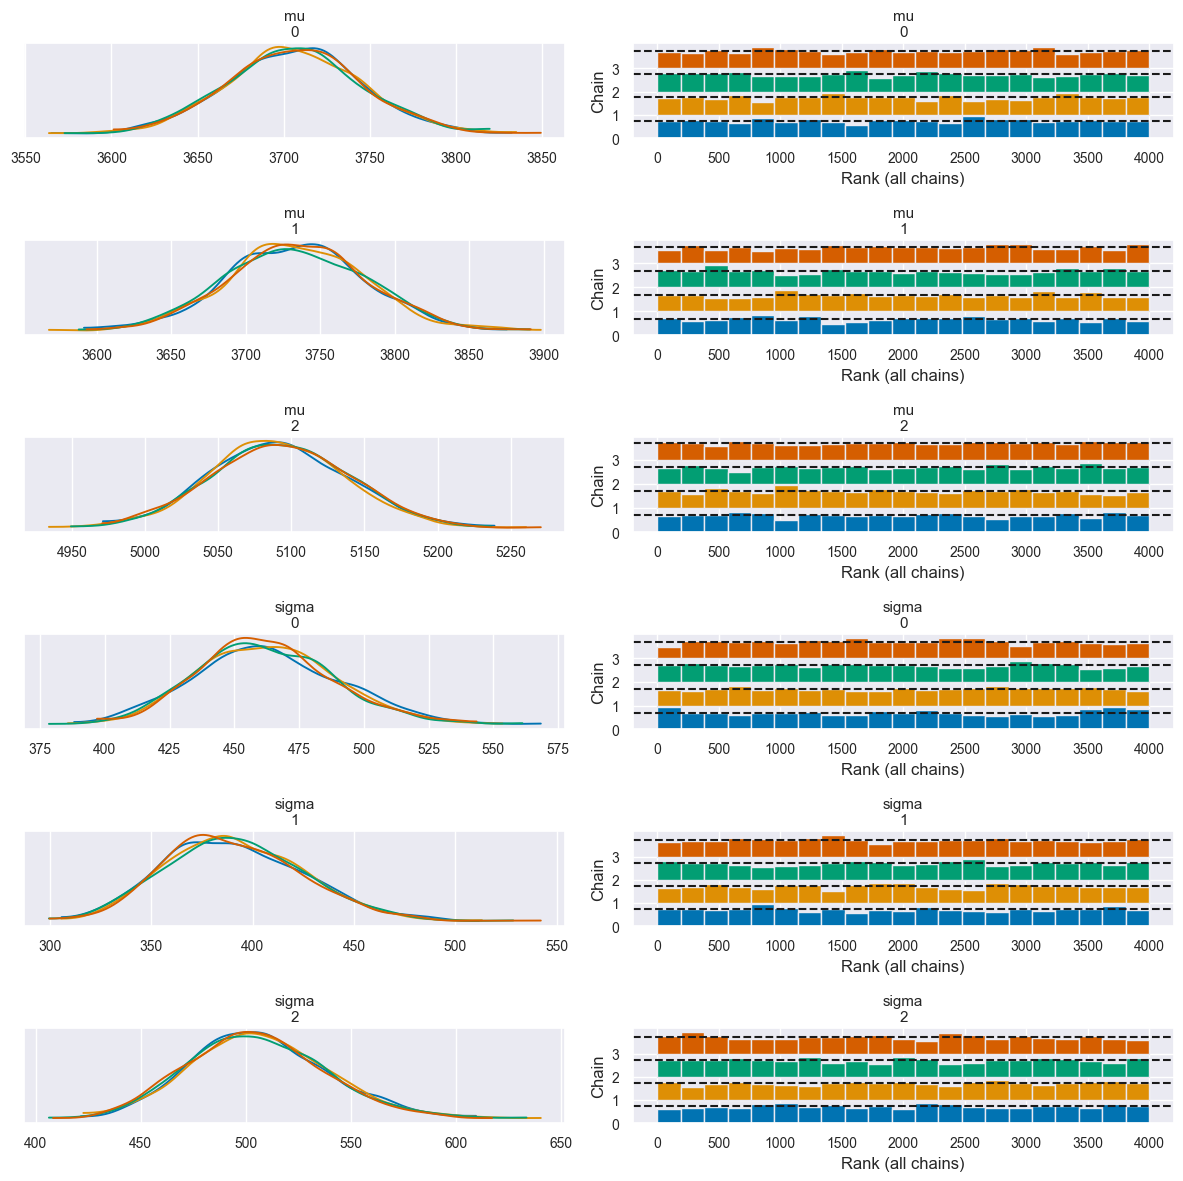

In [21]:
axes = az.plot_trace(idata3, compact=False, divergences="bottom", kind="rank_bars")
plt.tight_layout()

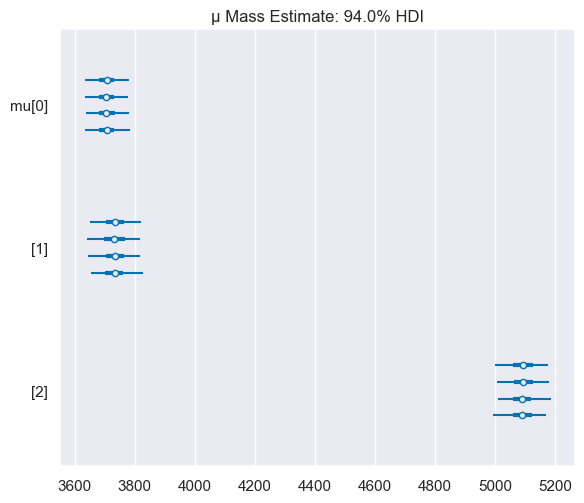

In [22]:
axes = az.plot_forest(
    idata3,
    var_names=["mu"],
)
axes[0].set_title("μ Mass Estimate: 94.0% HDI")
plt.tight_layout()

Text(0.5, 1.0, 'σ Mass Estimate: 94.0% HDI')

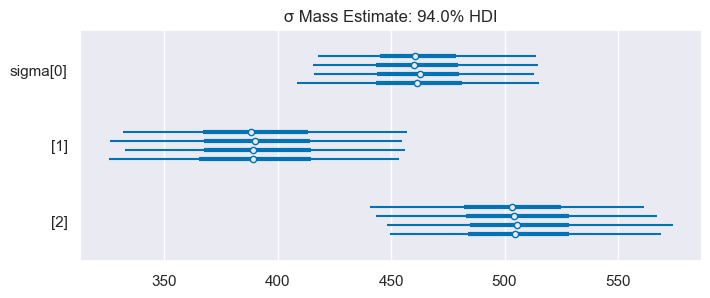

In [18]:
axes = az.plot_forest(idata3, var_names=["sigma"], figsize=(8, 3))
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

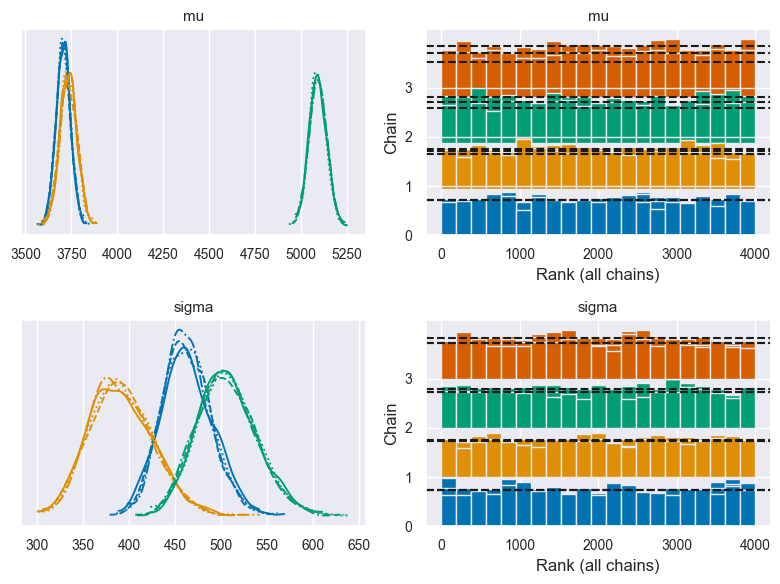

In [20]:
az.plot_trace(idata3, divergences="bottom", kind="rank_bars", figsize=(8, 6))
plt.tight_layout()

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor